## California Housing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


**Get the data. Make a copy.**

In [2]:
housing_data = pd.read_csv("housing.csv")
data = housing_data.copy()

**Split the data into test and training sets.**

In [14]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=11)

## Getting a grasp on our data

In [15]:
data_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20025,-119.05,36.07,21.0,2472.0,523.0,1238.0,504.0,1.7756,62900.0,INLAND
10772,-117.89,33.66,32.0,2736.0,550.0,1279.0,534.0,5.5422,253100.0,<1H OCEAN
16691,-120.61,35.13,16.0,3431.0,721.0,1777.0,701.0,2.7301,190400.0,<1H OCEAN
11946,-117.43,33.93,31.0,1273.0,262.0,686.0,254.0,2.4922,109400.0,INLAND
6532,-118.08,34.07,32.0,4089.0,975.0,3775.0,955.0,3.2900,205500.0,<1H OCEAN


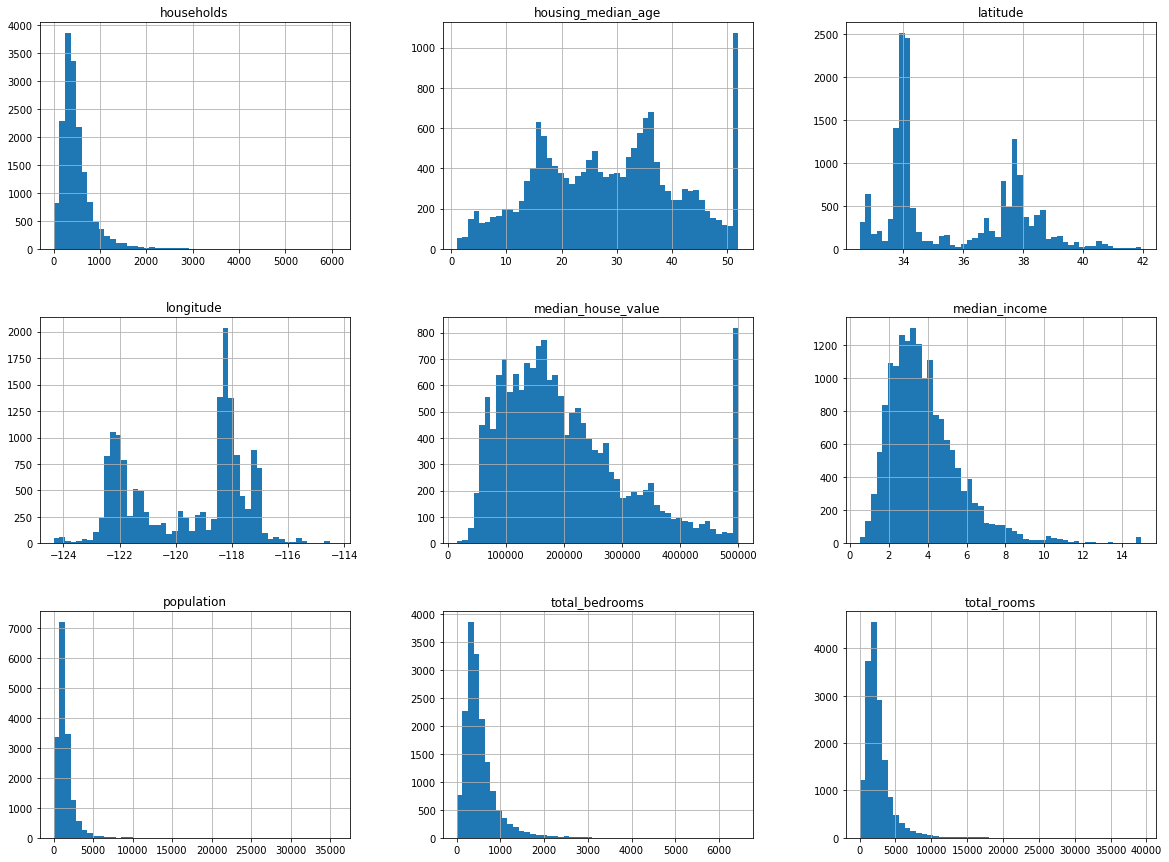

In [16]:
data_train.hist(bins=50,figsize=(20,15))
plt.show()

<br/>**Visualizing high-density areas**<br/>

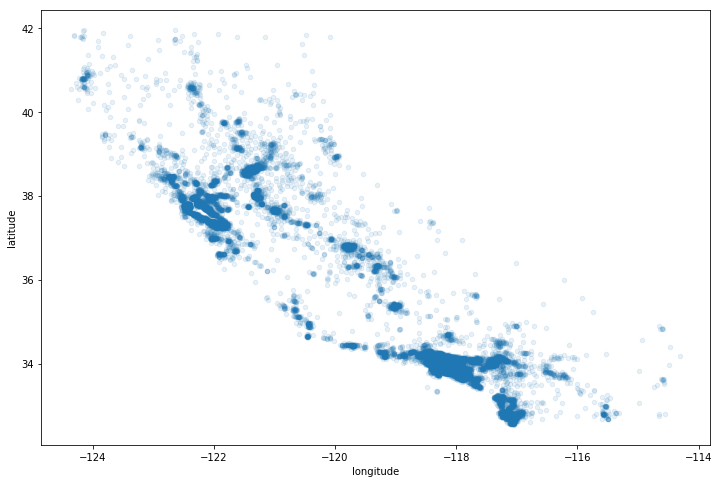

In [17]:
data_train.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1,figsize=(12,8));

**Looking for correlations**

In [18]:
corr_matrix = data_train.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925544,-0.107555,0.040180,0.063056,0.092393,0.048813,-0.007748,-0.045353
latitude,-0.925544,1.000000,0.013020,-0.033059,-0.061811,-0.103613,-0.066213,-0.086324,-0.143261
housing_median_age,-0.107555,0.013020,1.000000,-0.358620,-0.318094,-0.293012,-0.300210,-0.123796,0.098904
total_rooms,0.040180,-0.033059,-0.358620,1.000000,0.931403,0.855730,0.918158,0.201375,0.135040
total_bedrooms,0.063056,-0.061811,-0.318094,0.931403,1.000000,0.877055,0.979616,-0.002587,0.050834
population,0.092393,-0.103613,-0.293012,0.855730,0.877055,1.000000,0.906483,0.008213,-0.022360
households,0.048813,-0.066213,-0.300210,0.918158,0.979616,0.906483,1.000000,0.017447,0.066778
median_income,-0.007748,-0.086324,-0.123796,0.201375,-0.002587,0.008213,0.017447,1.000000,0.689227
median_house_value,-0.045353,-0.143261,0.098904,0.135040,0.050834,-0.022360,0.066778,0.689227,1.000000


In [19]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689227
total_rooms           0.135040
housing_median_age    0.098904
households            0.066778
total_bedrooms        0.050834
population           -0.022360
longitude            -0.045353
latitude             -0.143261
Name: median_house_value, dtype: float64

## Cleaning the data

Do we have any missing values?

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 20025 to 10137
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16347 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


Mariano had a look at the csv data and searched for empty values. We were able to confirm that there are 207 empty values (in the given data set) for total_bedrooms. In the training data, there are 165 empty values for total_bedrooms. Let's get rid of these!

In [21]:
data_train = data_train.dropna(axis=0,how='any')

We also have capped values for the median_house_value which can improperly influence our experiment/model/results. Since we cannot reconstruct these missing labels, we opted to drop them from the training data.

In [29]:
data_train = data_train.drop(data_train[(data_train['median_house_value'] > 500000) == True].index)

In [31]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15583 entries, 20025 to 10137
Data columns (total 10 columns):
longitude             15583 non-null float64
latitude              15583 non-null float64
housing_median_age    15583 non-null float64
total_rooms           15583 non-null float64
total_bedrooms        15583 non-null float64
population            15583 non-null float64
households            15583 non-null float64
median_income         15583 non-null float64
median_house_value    15583 non-null float64
ocean_proximity       15583 non-null object
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


** One hot encoding for the ocean_proximity feature**<br/>

In [33]:
data_train['ocean_proximity'].value_counts()

<1H OCEAN     6804
INLAND        5174
NEAR OCEAN    1906
NEAR BAY      1694
ISLAND           5
Name: ocean_proximity, dtype: int64

In [34]:
housing_cat = data_train['ocean_proximity']
housing_cat_encoded,housing_categories = housing_cat.factorize()

In [35]:
housing_categories

Index(['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND'], dtype='object')

In [36]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

In [37]:
housing_cat_1hot

<15583x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15583 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Feature Scaling ##

<br/> We opted for standardization as opposed to normalization. <br/>

In [43]:
##ANDREAS, I AM NOT FINISHED HERE...........


scaler = StandardScaler()
data_scaled = (scaler.fit(data_train.iloc[:,:-1]))
print (scaler.mean_)
data_scaled = (scaler.transform(data_train.iloc[:,:-1]))



[-1.19562629e+02  3.56508875e+01  2.84763524e+01  2.61577443e+03
  5.38695181e+02  1.44087101e+03  5.00092665e+02  3.66565772e+00
  1.91568921e+05]
